In [197]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import time
import os
import copy
from tqdm import tqdm
import matplotlib.pyplot as plt
torch.cuda.empty_cache()
import warnings
warnings.filterwarnings("ignore")

In [198]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [199]:
data_dir = "/home/atik/Documents/Summer_1/data/"

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
num_classes = len(image_datasets['train'].classes)

In [200]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    y_loss = {}  # loss history
    y_loss['train'] = []
    y_loss['val'] = []
    y_err = {}
    y_err['train'] = []
    y_err['val'] = []
    y_acc = {}
    y_acc['train'] = []
    y_acc['val'] = []

    x_epoch = []
    fig = plt.figure(figsize=(10,3))
    ax0 = fig.add_subplot(131, title="loss")
    ax1 = fig.add_subplot(132, title="top1err")
    ax2 = fig.add_subplot(133, title="accuracy")

    def draw_curve(current_epoch):
        x_epoch.append(current_epoch)
        ax0.plot(x_epoch, y_loss['train'], linestyle='solid', label='train')
        ax0.plot(x_epoch, y_loss['val'], linestyle='solid', label='val')
        ax1.plot(x_epoch, y_err['train'], linestyle='solid', label='train')
        ax1.plot(x_epoch, y_err['val'], linestyle='solid', label='val')
        ax2.plot(x_epoch, y_acc['train'], linestyle='solid', label='train')
        ax2.plot(x_epoch, y_acc['val'], linestyle='solid', label='val')
        plt.subplots_adjust(wspace=0.5)
        if current_epoch == 0:
            ax0.legend()
            ax1.legend()
        #fig.savefig(os.path.join('/home/atik/Documents/Summer_1', 'train.jpg'))
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_acc = epoch_acc.cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            
            y_loss[phase].append(epoch_loss)
            y_err[phase].append(1.0 - epoch_acc)
            y_acc[phase].append(epoch_acc)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                draw_curve(epoch)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [201]:
import torchvision.models as models
model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes, bias=True)
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [202]:
from torchsummary import summary
print(summary(model, input_size=(3, 224, 224)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

Epoch 0/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.85it/s]


train Loss: 5.3826 Acc: 0.0173


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.34it/s]


val Loss: 5.0662 Acc: 0.0373

Epoch 1/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.84it/s]


train Loss: 4.8107 Acc: 0.0612


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.46it/s]


val Loss: 4.8072 Acc: 0.0832

Epoch 2/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.83it/s]


train Loss: 4.3918 Acc: 0.1081


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.64it/s]


val Loss: 4.3809 Acc: 0.1248

Epoch 3/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.80it/s]


train Loss: 3.9978 Acc: 0.1609


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.56it/s]


val Loss: 4.1537 Acc: 0.1604

Epoch 4/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.82it/s]


train Loss: 3.6294 Acc: 0.2166


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.70it/s]


val Loss: 3.9730 Acc: 0.1977

Epoch 5/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.76it/s]


train Loss: 3.2774 Acc: 0.2690


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.37it/s]


val Loss: 3.7857 Acc: 0.2242

Epoch 6/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.77it/s]


train Loss: 2.9883 Acc: 0.3216


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.01it/s]


val Loss: 3.6252 Acc: 0.2514

Epoch 7/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.82it/s]


train Loss: 2.7317 Acc: 0.3684


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.03it/s]


val Loss: 3.5353 Acc: 0.2717

Epoch 8/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.80it/s]


train Loss: 2.4743 Acc: 0.4181


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.75it/s]


val Loss: 3.5420 Acc: 0.2715

Epoch 9/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.71it/s]


train Loss: 2.2334 Acc: 0.4641


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.06it/s]


val Loss: 3.4714 Acc: 0.2926

Epoch 10/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.77it/s]


train Loss: 1.9448 Acc: 0.5275


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.91it/s]


val Loss: 3.4792 Acc: 0.3016

Epoch 11/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.74it/s]


train Loss: 1.7219 Acc: 0.5768


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.27it/s]


val Loss: 3.4498 Acc: 0.3064

Epoch 12/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.76it/s]


train Loss: 1.5231 Acc: 0.6194


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.26it/s]


val Loss: 3.5722 Acc: 0.2977

Epoch 13/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.66it/s]


train Loss: 1.3532 Acc: 0.6583


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.36it/s]


val Loss: 3.6157 Acc: 0.3111

Epoch 14/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.74it/s]


train Loss: 1.1773 Acc: 0.7020


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.00it/s]


val Loss: 3.6784 Acc: 0.3139

Epoch 15/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.65it/s]


train Loss: 0.9198 Acc: 0.7684


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.89it/s]


val Loss: 3.7086 Acc: 0.3129

Epoch 16/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.63it/s]


train Loss: 0.7450 Acc: 0.8125


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.11it/s]


val Loss: 3.7922 Acc: 0.3082

Epoch 17/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.67it/s]


train Loss: 0.6152 Acc: 0.8490


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.93it/s]


val Loss: 3.7709 Acc: 0.3166

Epoch 18/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.71it/s]


train Loss: 0.4957 Acc: 0.8811


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.82it/s]


val Loss: 3.8923 Acc: 0.3170

Epoch 19/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.68it/s]


train Loss: 0.4277 Acc: 0.8961


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.02it/s]


val Loss: 3.9998 Acc: 0.3090

Epoch 20/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.74it/s]


train Loss: 0.2785 Acc: 0.9407


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.17it/s]


val Loss: 3.9945 Acc: 0.3154

Epoch 21/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


train Loss: 0.1860 Acc: 0.9684


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.05it/s]


val Loss: 3.9393 Acc: 0.3271

Epoch 22/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


train Loss: 0.1313 Acc: 0.9798


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.64it/s]


val Loss: 3.9672 Acc: 0.3271

Epoch 23/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.73it/s]


train Loss: 0.1000 Acc: 0.9877


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.05it/s]


val Loss: 3.9847 Acc: 0.3275

Epoch 24/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.76it/s]


train Loss: 0.0714 Acc: 0.9932


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.16it/s]


val Loss: 4.0882 Acc: 0.3215

Epoch 25/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


train Loss: 0.0507 Acc: 0.9962


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.02it/s]


val Loss: 4.0155 Acc: 0.3314

Epoch 26/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


train Loss: 0.0379 Acc: 0.9980


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.08it/s]


val Loss: 4.0246 Acc: 0.3396

Epoch 27/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.75it/s]


train Loss: 0.0314 Acc: 0.9988


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.17it/s]


val Loss: 4.0541 Acc: 0.3361

Epoch 28/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.79it/s]


train Loss: 0.0278 Acc: 0.9986


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 17.04it/s]


val Loss: 4.0807 Acc: 0.3334

Epoch 29/29
----------


100%|█████████████████████████████████████████| 400/400 [00:31<00:00, 12.78it/s]


train Loss: 0.0226 Acc: 0.9994


100%|███████████████████████████████████████████| 80/80 [00:04<00:00, 16.98it/s]


val Loss: 4.0755 Acc: 0.3332

Training complete in 18m 3s
Best val Acc: 0.339648


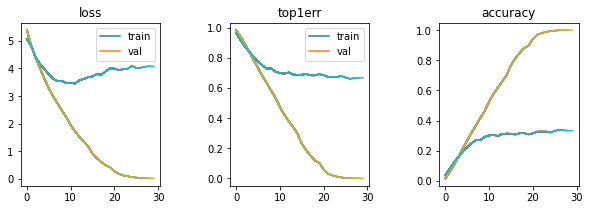

In [203]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=1e-2, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.9)

model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=30)